<a href="https://colab.research.google.com/github/bboerschinger/colabs/blob/master/2023_02_24_Flax_MNIST_on_TPUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on https://flax.readthedocs.io/en/latest/getting_started.html.

Notable changes:

* Data-parallel TPU training
* Instrument the CNN to return intermediate results for visualization

In [ ]:
!pip install 'flax<=0.6.5'  # Colab TPU only works with jax 0.3.25.
!pip install clu
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are inst

In [ ]:
from clu import deterministic_data
from clu import metrics
import flax
from flax.training import train_state as train_state_lib
from flax import linen as nn
import jax
from jax import numpy as jnp
import optax

import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

mnist_builder = tfds.builder('mnist')
mnist_builder.download_and_prepare()

batch_size = 512
local_batch_size = batch_size // jax.device_count()
print(f'Global batch_size {batch_size}, local batch_size {local_batch_size}')

def mnist_preproc_fn(mnist_example):
  return {
      'image': tf.cast(mnist_example['image'], tf.float32) / 255.0,
      'label': mnist_example['label'],
  }

train_ds = deterministic_data.create_dataset(
    dataset_builder=mnist_builder,
    split=tfds.split_for_jax_process('train'),
    shuffle_buffer_size=100,
    batch_dims=[jax.local_device_count(), local_batch_size],
    num_epochs=1,
    preprocess_fn=mnist_preproc_fn,
    shuffle=True,
    rng=jax.random.PRNGKey(42))

test_ds = deterministic_data.create_dataset(
    dataset_builder=mnist_builder,
    split=tfds.split_for_jax_process('test'),
    batch_dims=[jax.local_device_count(), local_batch_size],
    num_epochs=1,
    preprocess_fn=mnist_preproc_fn,
    shuffle=False)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Global batch_size 512, local batch_size 64


In [ ]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x, return_states=False):
    """x: <float>[batch_size, 28, 28, 1]"""
    states = []

    def _maybe_append(x):
      if return_states:
        states.append(x)

    # <float>[batch_size, 28, 28, 32]
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    _maybe_append(x)
    # <float>[batch_size, 14, 14, 32]
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    _maybe_append(x)
    # <float>[batch_size, 14, 14, 64]
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    _maybe_append(x)
    # <float>[batch_size, 7, 7, 64]
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    _maybe_append(x)
    # <float>[batch_size, 3136]
    x = x.reshape((x.shape[0], -1))
    # <float>[batch_size, 256]
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    # <float>[batch_size, 10]
    x = nn.Dense(features=10)(x)
    return x, states

@flax.struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

class TrainState(train_state_lib.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return TrainState.create(
      apply_fn=module.apply, 
      params=params, 
      tx=tx,
      metrics=Metrics.empty())

def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits, _ = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss

  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  # !!! CRUCIAL - CROSS-REPLICA AVERAGING OF GRADIENTS !!!
  grads = jax.lax.pmean(grads, axis_name='devices')
  state = state.apply_gradients(grads=grads)
  return state

def compute_metrics(state, batch):
  # <float>[batch_size, 10]
  logits, _ = state.apply_fn({'params': state.params}, batch['image'])
  # <float>[]
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()

  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)

  state = state.replace(metrics=metrics)
  return state

# This runs on your host / non-replicated.
model = CNN()
state = create_train_state(module=model, 
                           rng=jax.random.PRNGKey(42), 
                           learning_rate=3e-4)
# Make sure to replicate them to the device(s).
state = flax.jax_utils.replicate(state, devices=jax.local_devices())

# pmap the train and eval state - this adds the "device" dimension we need for
# data-parallel training.
pmapped_train_step = jax.pmap(train_step, axis_name='devices')
pmapped_compute_metrics_step = jax.pmap(compute_metrics, axis_name='devices')

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

EPOCHS = 20
for epoch in range(EPOCHS):
  for step, batch in enumerate(train_ds.as_numpy_iterator()):
    state = pmapped_train_step(state, batch)
    state = pmapped_compute_metrics_step(state=state, batch=batch)

  for metric,value in state.metrics.unreplicate().compute().items():
    metrics_history[f'train_{metric}'].append(value)

  state = state.replace(metrics=flax.jax_utils.replicate(state.metrics.empty(),
                                                         devices=jax.local_devices()))

  # Compute metrics on the test set after each training epoch
  test_state = state
  for test_batch in test_ds.as_numpy_iterator():
    test_state = pmapped_compute_metrics_step(state=test_state, batch=test_batch)

  for metric,value in test_state.metrics.unreplicate().compute().items():
    metrics_history[f'test_{metric}'].append(value)

  print(f"train epoch: {epoch + 1}, "
        f"loss: {metrics_history['train_loss'][-1]}, "
        f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
  print(f"test epoch: {epoch + 1}, "
        f"loss: {metrics_history['test_loss'][-1]}, "
        f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.5926086902618408, accuracy: 85.96421813964844
test epoch: 1, loss: 0.22757306694984436, accuracy: 93.50328826904297
train epoch: 2, loss: 0.18485967814922333, accuracy: 94.43109893798828
test epoch: 2, loss: 0.13258898258209229, accuracy: 95.97039794921875
train epoch: 3, loss: 0.11572382599115372, accuracy: 96.60791015625
test epoch: 3, loss: 0.09244686365127563, accuracy: 96.95723724365234
train epoch: 4, loss: 0.08821511268615723, accuracy: 97.51602935791016
test epoch: 4, loss: 0.07208765298128128, accuracy: 97.45065307617188
train epoch: 5, loss: 0.05951368063688278, accuracy: 98.31731414794922
test epoch: 5, loss: 0.06090592220425606, accuracy: 98.10855102539062
train epoch: 6, loss: 0.06466193497180939, accuracy: 98.35737609863281
test epoch: 6, loss: 0.05335735157132149, accuracy: 98.10855102539062
train epoch: 7, loss: 0.04728700593113899, accuracy: 98.71794891357422
test epoch: 7, loss: 0.04728613421320915, accuracy: 98.19078826904297
train epoch: 8, l

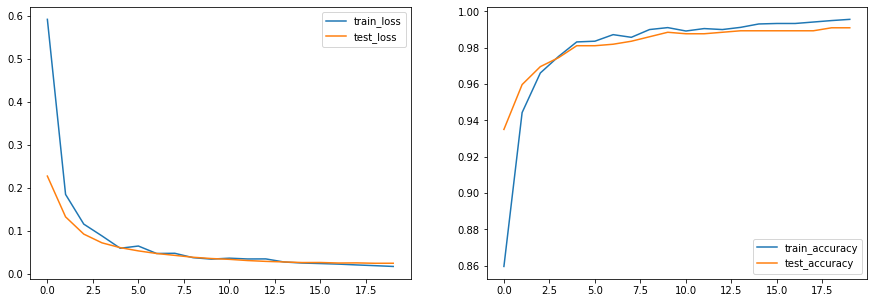

In [ ]:
import matplotlib.pyplot as plt

fig, (loss_plot, accuracy_plot) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

loss_plot.plot(range(EPOCHS), metrics_history['train_loss'], label='train_loss')
loss_plot.plot(range(EPOCHS), metrics_history['test_loss'], label='test_loss')
loss_plot.legend()

accuracy_plot.plot(range(EPOCHS), metrics_history['train_accuracy'], label='train_accuracy')
accuracy_plot.plot(range(EPOCHS), metrics_history['test_accuracy'], label='test_accuracy')
accuracy_plot.legend()

In [ ]:
# Get one set of parameters, and run one batch returning the intermediate
# states so we can visualize them alongside the filters.
unreplicated_params = flax.jax_utils.unreplicate(state.params)
image_batch = flax.jax_utils.unreplicate(next(iter(train_ds)))
_, states = model.apply({'params': unreplicated_params}, image_batch['image'], return_states=True)

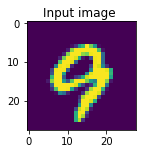

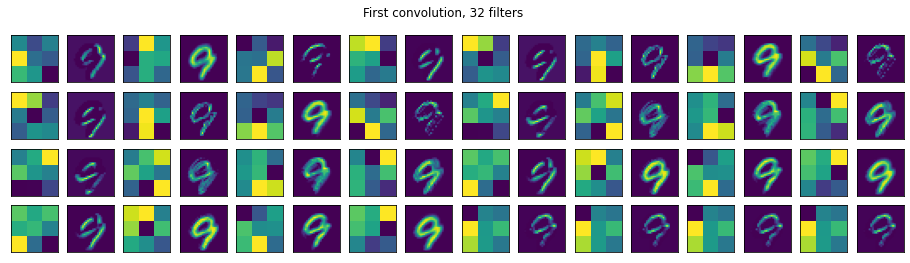

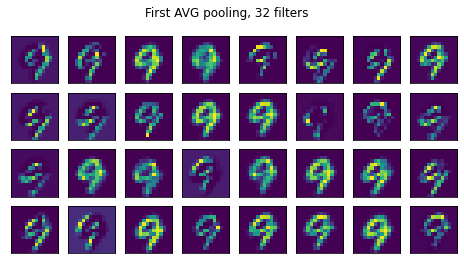

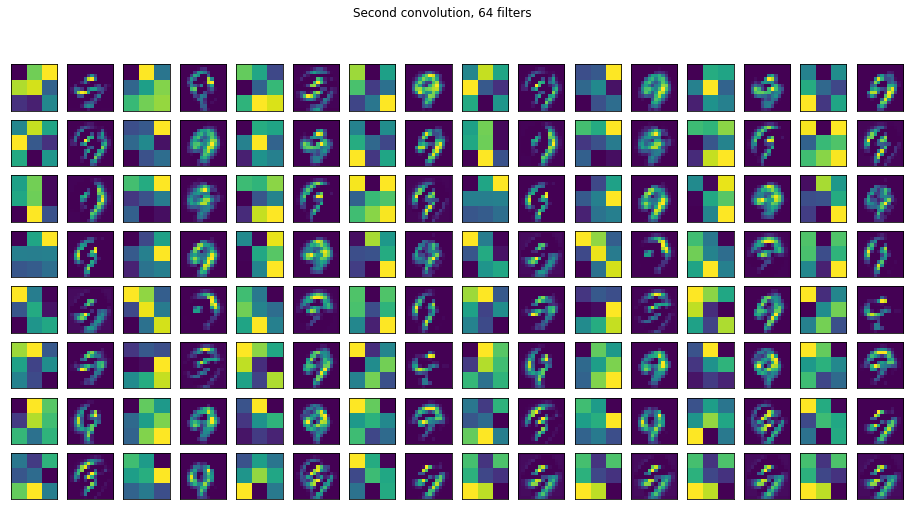

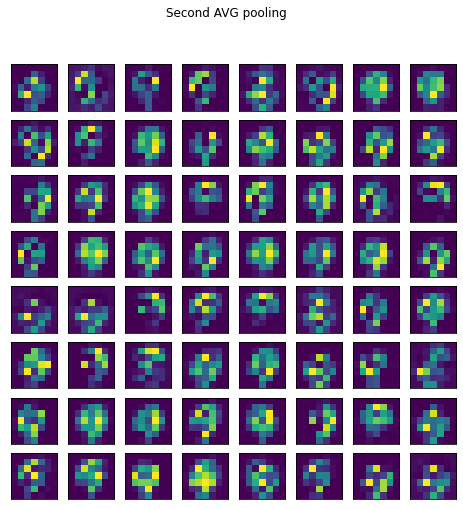

In [ ]:
look_at_image = 10 #@param

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(2)
fig.set_figheight(2)
fig.suptitle('Input image')
ax.imshow(image_batch['image'][look_at_image, :, :, 0])

fig, axs = plt.subplots(4, 16)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle('First convolution, 32 filters')
for (row_axs, row_start) in zip(axs, range(0, 32, 8)):
  for offset in range(0, 16, 2):
    filter_cell = row_axs[offset]
    image_cell = row_axs[offset+1]
    filter_cell.set_xticks([])
    filter_cell.set_yticks([])
    image_cell.set_xticks([])
    image_cell.set_yticks([])

    filter_cell.imshow(unreplicated_params['Conv_0']['kernel'][:, :, 0, row_start + offset])
    image_cell.imshow(states[0][look_at_image, :, :, row_start + offset])

fig, axs = plt.subplots(4, 8)
fig.set_figwidth(8)
fig.set_figheight(4)
fig.suptitle('First AVG pooling, 32 filters')
for (row_axs, row_start) in zip(axs, range(0, 32, 8)):
  for offset in range(0, 8):
    image_cell = row_axs[offset]
    image_cell.set_xticks([])
    image_cell.set_yticks([])
    image_cell.imshow(states[1][look_at_image, :, :, row_start + offset])

fig, axs = plt.subplots(8, 16)
fig.set_figwidth(16)
fig.set_figheight(8)
fig.suptitle('Second convolution, 64 filters')
for (row_axs, row_start) in zip(axs, range(0, 64, 8)):
  for offset in range(0, 16, 2):
    filter_cell = row_axs[offset]
    image_cell = row_axs[offset+1]
    filter_cell.set_xticks([])
    filter_cell.set_yticks([])
    image_cell.set_xticks([])
    image_cell.set_yticks([])

    filter_cell.imshow(unreplicated_params['Conv_1']['kernel'][:, :, 0, row_start + offset])
    image_cell.imshow(states[2][look_at_image, :, :, row_start + offset])

fig, axs = plt.subplots(8, 8)
fig.set_figwidth(8)
fig.set_figheight(8)
fig.suptitle('Second AVG pooling')
for (row_axs, row_start) in zip(axs, range(0, 64, 8)):
  for offset in range(0, 8):
    image_cell = row_axs[offset]
    image_cell.set_xticks([])
    image_cell.set_yticks([])
    image_cell.imshow(states[3][look_at_image, :, :, row_start + offset])